# Grammar-based Mutational Fuzzing
\todo{}

In this chapter, we are going to expand on what we have learned in the chapters on [blackbox](MutationFuzzer.ipynb) and [greybox](Greybox_Fuzzing.ipynb) mutational fuzzing. Into these mutational fuzzers, we integrate the capability to generate *valid program inputs*. We explore dictionaries, grammars, and structural mutators. 

This chapter is *self-contained*. Don't worry if you haven't actually read the chapters on mutational fuzzing 😊

**Related chapters**

* [Blackbox Mutational Fuzzing](MutationFuzzer.ipynb)
* [Greybox Mutational Fuzzing](Greybox_Fuzzing.ipynb)
* [Grammar-based Generational Fuzzing](Grammars.ipynb)

In [1]:
import fuzzingbook_utils

## Dictionary: Injecting Important Keywords
Today, dictionaries are the main mechanism to inform a greybox fuzzer about important keywords in the input.

\todo{}
* **Seed**. \todo{}
* **Mutator**. \todo{}
* **PowerSchedule**. \todo{}
* **GreyboxFuzzer**. \todo{}
* **FunctionCoverageRunner**. \todo{}

In [3]:
from Greybox_Fuzzing import Mutator, Seed, PowerSchedule, GreyboxFuzzer

In [4]:
class DictMutator(Mutator):
    def __init__(self, dictionary):
        super().__init__()
        self.dictionary = dictionary
        self.mutators.append(self.insert_from_dictionary)
        
    def insert_from_dictionary(self,s):
        """Returns s with a keyword from the dictionary inserted"""
        pos = random.randint(0, len(s))
        random_keyword = random.choice(self.dictionary)
        return s[:pos] + random_keyword + s[pos:]

In [37]:
from html.parser import HTMLParser

In [5]:
# create wrapper function
def my_parser(inp):
    parser = HTMLParser()  # resets the HTMLParser object for every fuzz input
    parser.feed(inp)

In [39]:
from Greybox_Fuzzing import FunctionCoverageRunner
import time, random

In [6]:
n = 5000
seed_input = " " # empty seed
parser_runner = FunctionCoverageRunner(my_parser)
greybox_fuzzer  = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
greybox_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 2.19 seconds to generate and execute 5000 inputs.'

In [7]:
n=5000
html_dict = ["<a>","</a>","<a/>", "='a'"]
dict_fuzzer = GreyboxFuzzer([seed_input], DictMutator(html_dict), PowerSchedule())
start = time.time()
dict_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 14.73 seconds to generate and execute 5000 inputs.'

How do the fuzzers compare in terms of coverage over time?

In [8]:
from Coverage import population_coverage

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

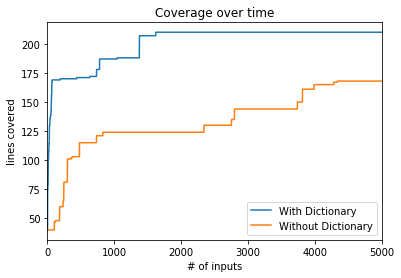

In [10]:
_, dict_coverage = population_coverage(dict_fuzzer.inputs, my_parser)
_, greybox_coverage = population_coverage(greybox_fuzzer.inputs, my_parser)
line_dict, = plt.plot(dict_coverage, label="With Dictionary")
line_greybox, = plt.plot(greybox_coverage, label="Without Dictionary")
plt.legend(handles=[line_dict, line_greybox])
plt.xlim(0,n)
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')
plt.show()

## Structural Mutation of Valid Seeds
\todo{} 

This allows to _mutate_ existing inputs while preserving syntactical correctness, and to _reuse_ fragments from existing inputs while generating new ones.  The combination of parsing and fuzzing, as demonstrated in this chapter, has been highly successful in practice: The _LangFuzz_ fuzzer for JavaScript has found more than 2,600 bugs in JavaScript interpreters this way.

Recombining parsed inputs was pioneered by _Langfuzz_ \cite{Holler2012}. The main challenge is that program inputs often carry additional constraints beyond what is described by the syntax. For example, in Java, one needs to declare a variable (using a specific format for declaration) before it can be used in an expression. This restriction is not captured in the _Java CFG_. Checking for type correctness is another example for additional restrictions carried by program definitions.

When fuzzing compilers and interpreters, naive generation of programs using the language *CFG* often fails to achieve significant deeper coverage due to these kinds of checks external to the grammar. Holler et al. suggests using pre-existing valid code fragments to get around these restrictions. The idea is that the pre-existing valid code fragments already conform to the restrictions external to the grammar, and can often provide a means to evade validity checks.

In [11]:
import string
from Grammars import is_valid_grammar, srange

\todo{}

In [12]:
XML_TOKENS = {"<id>","<text>"}

XML_GRAMMAR = {
    "<start>": ["<xml-tree>"],
    "<xml-tree>": ["<text>",
                   "<xml-open-tag><xml-tree><xml-close-tag>", 
                   "<xml-openclose-tag>", 
                   "<xml-tree><xml-tree>"],
    "<xml-open-tag>":      ["<<id>>", "<<id> <xml-attribute>>"],
    "<xml-openclose-tag>": ["<<id>/>", "<<id> <xml-attribute>/>"],
    "<xml-close-tag>":     ["</<id>>"],
    "<xml-attribute>" :    ["<id>=<id>", "<xml-attribute> <xml-attribute>"],
    "<id>":                ["<letter>", "<id><letter>"],
    "<text>" :             ["<text><letter_space>","<letter_space>"],
    "<letter>":            srange(string.ascii_letters + string.digits +"\""+"'"+"."),
    "<letter_space>":      srange(string.ascii_letters + string.digits +"\""+"'"+" "+"\t"),
}

assert is_valid_grammar(XML_GRAMMAR)

In [13]:
from Parser import EarleyParser
from GrammarFuzzer import display_tree

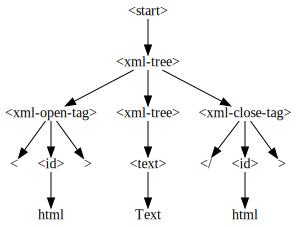

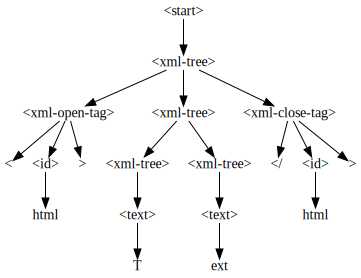

In [14]:
parser = EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS)

for tree in parser.parse("<html>Text</html>"):
    display_tree(tree)

In [15]:
from Parser import terminals
import signal

In [16]:
class Timeout(Exception):
    pass
def timeout(signum, frame):
    raise Timeout()
    
signal.signal(signal.SIGALRM, timeout)

<Handlers.SIG_DFL: 0>

In [17]:
class SmartMutator(Mutator):
    
    def __init__(self, parser):
        self.parser = parser
        # Init each symbol in fragments dict w/ empty set
        self.fragments = {k: [] for k in self.parser.cgrammar}
        super().__init__()
        
    def is_excluded(self, symbol):
        return ((not symbol in self.parser.grammar()) or
                symbol in self.parser.tokens or
                symbol in terminals(self.parser.grammar()))
    
    def add_fragment(self, structure):
        (symbol, children) = structure
        if not self.is_excluded(symbol):
            self.fragments[symbol].append(structure)
            for substructure in children:
                self.add_fragment(substructure)

    def add_to_fragment_pool(self, seed):
        try: # only allow quick parsing of 200ms
            signal.setitimer(signal.ITIMER_REAL, 0.2)
            seed.structure = next(self.parser.parse(seed.data))
            signal.setitimer(signal.ITIMER_REAL, 0)
            
            self.add_fragment(seed.structure)
            seed.has_structure = True
        except (SyntaxError, Timeout):
            seed.has_structure = False
            signal.setitimer(signal.ITIMER_REAL, 0)

In [18]:
from GrammarFuzzer import tree_to_string

In [19]:
parser.parse("<b>Text</b>")

<generator object EarleyParser.parse at 0x7f7abec2d3b8>

In [20]:
simple_seed = Seed("<b>Text</b>")
parser = EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS)
smart_mutator = SmartMutator(parser)
smart_mutator.add_to_fragment_pool(simple_seed)
for key in smart_mutator.fragments:
    print(key)
    for f in smart_mutator.fragments[key]:
        print("|-%s" % tree_to_string(f))

<start>
|-<b>Text</b>
<xml-tree>
|-<b>Text</b>
|-Text
<xml-open-tag>
|-<b>
<xml-openclose-tag>
<xml-close-tag>
|-</b>
<xml-attribute>
<id>
<text>
<letter>
<letter_space>


In [21]:
class SmartMutator(SmartMutator):
    def __init__(self, parser):
        super().__init__(parser)
        self.mutators = [self.swap_substructure]
        self.seen_seeds = []
    
    def count_nodes(self, structure):
        symbol, children = structure
        if self.is_excluded(symbol):
            return 0
        return 1 + sum(map(self.count_nodes, children))
        
    def swap_substructure(self, seed):
        if seed.has_structure:
            n_nodes = self.count_nodes(seed.structure)
            self.to_swap = random.randint(2, n_nodes)

            def recursive_swap(structure):
                symbol, children = structure
                if self.is_excluded(symbol):
                    return symbol, children
            
                self.to_swap -= 1
                if self.to_swap == 0: 
                    return random.choice(list(self.fragments[symbol]))
                return symbol, list(map(recursive_swap, children))
            new_structure = recursive_swap(seed.structure)
            new_seed = Seed(tree_to_string(new_structure))
            new_seed.has_structure = True
            new_seed.structure = new_structure
            return new_seed
        return seed
    
    def mutate(self, seed):
        if not seed in self.seen_seeds:
            self.seen_seeds.append(seed)
            self.add_to_fragment_pool(seed)
        return super().mutate(seed)

In [22]:
valid_seed = Seed("<html><header><title>Hello</title></header><body>World<br/></body></html>")
smart_mutator = SmartMutator(parser)
smart_mutator.mutate(valid_seed)

<html><header><title><br/></title></header><body>World<br/></body></html>

In [23]:
class SmartMutator(SmartMutator):
    def __init__(self, parser):
        super().__init__(parser)
        self.mutators.append(self.delete_substructure)
    
    def delete_substructure(self, seed):
        if seed.has_structure:
            n_nodes = self.count_nodes(seed.structure)
            self.to_delete = random.randint(2, n_nodes)
        
            def recursive_delete(structure):
                symbol, children = structure
                if self.is_excluded(symbol):
                    return symbol, children
            
                self.to_delete -= 1
                if self.to_delete == 0: 
                    return symbol, []
                return symbol, list(map(recursive_delete, children))
            new_structure = recursive_delete(seed.structure)
            new_seed = Seed(tree_to_string(new_structure))
            new_seed.has_structure = True
            new_seed.structure = new_structure
            # do not return an empty new_seed
            if not new_seed.data: return seed
            else: return new_seed
        return seed

In [24]:
class SmartGreyboxFuzzer(GreyboxFuzzer):
    def __init__(self, seeds, dumb_mutator, smart_mutator, schedule):
        super().__init__(seeds, dumb_mutator, schedule)
        self.smart_mutator = smart_mutator
    
    def create_candidate(self):
        """Returns an input generated by structural mutation of a seed in the population"""
        seed = self.schedule.choose(self.population)
        smart_trials = 1 << random.randint(0,2)
        for i in range(smart_trials):
            seed = self.smart_mutator.mutate(seed)
        
        # Unstructured mutation
        candidate = seed.data
        if not seed.has_structure or 1 == random.randint(0, 1):
            dumb_trials = min(len(seed.data), 1 << random.randint(1,5))
            for i in range(dumb_trials):
                candidate = self.mutator.mutate(candidate)
        return candidate

In [25]:
class NonMutator(Mutator):
    def mutate(self, inp):
        return inp
    
n = 300
dumb_mutator = NonMutator()
smart_mutator = SmartMutator(EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS))
smart_greybox_fuzzer = SmartGreyboxFuzzer([valid_seed.data],
                                          dumb_mutator,
                                          smart_mutator, 
                                          PowerSchedule())
start = time.time()
smart_greybox_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took the smart greybox fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the smart greybox fuzzer 6.02 seconds to generate and execute 300 inputs.'

In [26]:
def print_stats(fuzzer):
    has_structure = 0
    for seed in fuzzer.population:
        if hasattr(seed, "has_structure") and seed.has_structure:
            has_structure += 1

    print("From the %d seeds in the population, %d (%0.2f%%) can be parsed." % (
        len(fuzzer.population),
        has_structure,
        100 * has_structure / len(fuzzer.population)))

In [27]:
print_stats(smart_greybox_fuzzer)

From the 13 seeds in the population, 8 (61.54%) can be parsed.


\todo{Summary. High validity, small population}

## Structural Mutation of Invalid Seeds
\todo{partial parsing}

In [28]:
invalid_seed = Seed("<html><body><i>World</i><br/>>/body></html>")
table = parser.chart_parse(invalid_seed.data, parser.start_symbol())
for column in table:
    print(column)
    print("---")

None chart[0]

---
< chart[1]

---
h chart[2]
<letter>:= h |(1,2)
<id>:= <letter> |(1,2)
---
t chart[3]
<letter>:= t |(2,3)
<id>:= <id> <letter> |(1,3)
---
m chart[4]
<letter>:= m |(3,4)
<id>:= <id> <letter> |(1,4)
---
l chart[5]
<letter>:= l |(4,5)
<id>:= <id> <letter> |(1,5)
---
> chart[6]
<xml-open-tag>:= < <id> > |(0,6)
---
< chart[7]

---
b chart[8]
<letter>:= b |(7,8)
<id>:= <letter> |(7,8)
---
o chart[9]
<letter>:= o |(8,9)
<id>:= <id> <letter> |(7,9)
---
d chart[10]
<letter>:= d |(9,10)
<id>:= <id> <letter> |(7,10)
---
y chart[11]
<letter>:= y |(10,11)
<id>:= <id> <letter> |(7,11)
---
> chart[12]
<xml-open-tag>:= < <id> > |(6,12)
---
< chart[13]

---
i chart[14]
<letter>:= i |(13,14)
<id>:= <letter> |(13,14)
---
> chart[15]
<xml-open-tag>:= < <id> > |(12,15)
---
W chart[16]
<letter_space>:= W |(15,16)
<text>:= <letter_space> |(15,16)
<xml-tree>:= <text> |(15,16)
---
o chart[17]
<letter_space>:= o |(16,17)
<text>:= <text> <letter_space> |(15,17)
<text>:= <letter_space> |(16,17)


In [29]:
cols = [col for col in table if col.states]
parsable = invalid_seed.data[:len(cols)-1]
validity = 100 * len(parsable) / len(invalid_seed.data)

"This much could be parsed successfully: %s (%0.1f%%)" % (parsable, validity)

'This much could be parsed successfully: <html><body><i>World</i><br/> (67.4%)'

In [30]:
class SmartMutator(SmartMutator):
    def add_to_fragment_pool(self, seed):
        super().add_to_fragment_pool(seed)
        if not seed.has_structure:
            try:
                signal.setitimer(signal.ITIMER_REAL, 0.2) # set 500ms timeout
                seed.regions = {k: set() for k in self.parser.cgrammar}
                for column in self.parser.chart_parse(seed.data, self.parser.start_symbol()):
                    for state in column.states:
                        if (not self.is_excluded(state.name) and
                                state.e_col.index - state.s_col.index > 1 and
                                state.finished()):
                            seed.regions[state.name].add((state.s_col.index, state.e_col.index))
                signal.setitimer(signal.ITIMER_REAL, 0) # cancel timeout
                seed.has_regions = True
            except Timeout:
                seed.has_regions = False
        else:
            seed.has_regions = False

In [31]:
smart_mutator = SmartMutator(parser)
smart_mutator.add_to_fragment_pool(invalid_seed)
for key in invalid_seed.regions:
    print(key)
    for (s,e) in invalid_seed.regions[key]:
        print("|-(%d,%d) : %s" % (s, e, invalid_seed.data[s:e]))

<start>
<xml-tree>
|-(17,19) : rl
|-(18,20) : ld
|-(24,29) : <br/>
|-(15,20) : World
|-(17,20) : rld
|-(12,24) : <i>World</i>
|-(15,18) : Wor
|-(16,20) : orld
|-(12,29) : <i>World</i><br/>
|-(15,19) : Worl
|-(16,19) : orl
|-(16,18) : or
|-(15,17) : Wo
<xml-open-tag>
|-(0,6) : <html>
|-(12,15) : <i>
|-(6,12) : <body>
<xml-openclose-tag>
|-(24,29) : <br/>
<xml-close-tag>
|-(20,24) : </i>
<xml-attribute>
<id>
<text>
<letter>
<letter_space>


In [32]:
class SmartMutator(SmartMutator):
    
    def swap_substructure(self, seed):
        if not seed.has_structure and seed.has_regions:
            regions = [r for r in seed.regions
                         if (len(seed.regions[r]) > 0 and
                            len(self.fragments[r]) > 0)]
            if len(regions) == 0: return seed
                
            key = random.choice(list(regions))
            s, e = random.choice(list(seed.regions[key]))
            swap_structure = random.choice(self.fragments[key])
            swap_string = tree_to_string(swap_structure)
            new_seed = Seed(seed.data[:s] + swap_string + seed.data[e:])
            new_seed.has_structure = False
            new_seed.has_regions = False
            return new_seed
        else:
            return super().swap_substructure(seed)
        
    def delete_substructure(self, seed):
        if not seed.has_structure and seed.has_regions:
            regions = [r for r in seed.regions
                         if len(seed.regions[r]) > 0]
            if len(regions) == 0: return seed

            key = random.choice(list(regions))
            s, e = random.choice(list(seed.regions[key]))
            new_seed = Seed(seed.data[:s] + seed.data[e:])
            new_seed.has_structure = False
            new_seed.has_regions = False
            return new_seed
        else:
            return super().delete_substructure(seed)

In [33]:
smart_mutator = SmartMutator(parser)
smart_mutator.add_to_fragment_pool(simple_seed)
smart_mutator.mutate(invalid_seed)

<html><body>World</i><br/>>/body></html>

In [34]:
n=1000

#seed1 = "<a><b>f</b><d c=e>g</d></a>"
seed1 = "<html a=b>Hi</html>"
dumb_mutator = Mutator()
parser = EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS)
smarter_mutator = SmartMutator(parser)
smarter_greybox_fuzzer = SmartGreyboxFuzzer([seed1],
                                            dumb_mutator,
                                            smarter_mutator, 
                                            PowerSchedule())
start = time.time()
smarter_greybox_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took the smarter greybox fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the smarter greybox fuzzer 16.04 seconds to generate and execute 1000 inputs.'

In [35]:
def print_more_stats(fuzzer, parser):
    print_stats(fuzzer)
    validity = 0
    total = 0
    for seed in fuzzer.population:
        if not seed.data: continue
        table = parser.chart_parse(seed.data, parser.start_symbol())
        cols = [col for col in table if col.states]
        parsable = invalid_seed.data[:len(cols)-1]
        validity += len(parsable) / len(seed.data)
        total += 1
    print("On average, %0.1f%% of a seed in the population can be successfully parsed." % (100 * validity / total))

In [36]:
print_more_stats(smarter_greybox_fuzzer, parser)

From the 241 seeds in the population, 1 (0.41%) can be parsed.
On average, 12.1% of a seed in the population can be successfully parsed.


\todo{Summary. Lower validity but larger population.}

\todo{Try it. Deferred parsing.}

## Validity-based Power Schedule
\todo{degree of validity, deferred parsing}

In [ ]:
import math
class AFLSmartSchedule(PowerSchedule):
    
    def __init__(self, parser, exponent):
        self.parser = parser
        self.exponent = exponent
    
    def parsable(self, seed):
        table = self.parser.chart_parse(seed.data, parser.start_symbol())
        cols = [col for col in table if col.states]
        return seed.data[:len(cols)-1]
    
    def degree_of_validity(self, seed):
        if hasattr(seed, "validity"): return seed.validity
        seed.validity = (len(self.parsable(seed)) / len(seed.data)
                         if len(seed.data) > 0 else 0)
        return seed.validity
    
    def assignEnergy(self, population):
        """Assign exponential energy proportional to degree of validity"""
        for seed in population:
            seed.energy = ((self.degree_of_validity(seed) / math.log(len(seed.data))) ** self.exponent
                           if len(seed.data) > 1 else 0)

In [ ]:
smart_schedule = AFLSmartSchedule(parser, 1)
print("%11s: %s" % ("Entire seed", simple_seed))
print("%11s: %s" % ("Parsable", smart_schedule.parsable(simple_seed)))

"Degree of validity: %0.2f%%" % (100 * smart_schedule.degree_of_validity(simple_seed))

In [ ]:
print("%11s: %s" % ("Entire seed", invalid_seed))
print("%11s: %s" % ("Parsable", smart_schedule.parsable(invalid_seed)))

"Degree of validity: %0.2f%%" % (100 * smart_schedule.degree_of_validity(invalid_seed))

In [ ]:
n=1000

seed1 = "<d c=e>g</d>"

dumb_mutator = Mutator()
parser = EarleyParser(XML_GRAMMAR, tokens=XML_TOKENS)
aflsmart_mutator = SmartMutator(parser)
aflsmart_schedule = AFLSmartSchedule(parser, 1)
aflsmart_greybox_fuzzer = SmartGreyboxFuzzer([seed1],
                                            dumb_mutator,
                                            aflsmart_mutator, 
                                            aflsmart_schedule)
start = time.time()
aflsmart_greybox_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took the aflsmart greybox fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

In [ ]:
print_more_stats(aflsmart_greybox_fuzzer, parser)

\todo{Summary. Maximize validity and coverage}

\todo{Reference [AFLSmart](https://github.com/aflsmart/aflsmart) and "[Smart Greybox Fuzzing](https://arxiv.org/abs/1811.09447)" \cite{aflsmart}}

## Lessons Learned

* We can generate a pool of fragments using the _LangFuzz_ approach, and use it to generate nearly valid strings.

## Next Steps

* In the [chapter on evolutionary fuzzing](EvoGrammarFuzzer.ipynb), we discuss how to systematically evolve a population of inputs through mutation and crossover operations (as discussed in this chapter) to achieve a specific goal such as code coverage.

## Background

Recombining parsed inputs was pioneered by _Langfuzz_ \cite{Holler2012}, which also gave its name to the main class of this chapter.

## Exercises


### Exercise 1: A Different LangFuzzer

Sometimes we do not want to use our pool of strings for various reasons – the number of items in the pool may be inadequate, or not varied enough. Extend the `LangFuzzer` to use a separate function to check if the number of items in the pool corresponding to the selected non-terminal is large enough (say greater than 10), and if not, use the tree expansion technique from `GrammarFuzzer` to patch the hole.

**Solution.** Here is a possible solution.  Before we can make use of `GrammarFuzzer`, we need to change it a little bit. GrammarFuzzer relies on the grammar being in the `fuzzing` format with the expansions represented as strings. Our `LangFuzzer` expects the expansions to be a list of tokens. So we fix the output of `GrammarFuzzer`.

In [ ]:
class LangFuzzer2(LangFuzzer):
    def __init__(self, parser, strings):
        super().__init__(parser, strings)
        self.gfuzz = GrammarFuzzer(parser.grammar())

    def check_diversity(self, pool):
        return len(pool) > 10

    def candidate(self):
        tree, nodes = random.choice(self.trees)
        interesting_nodes = [
            n for n in nodes if nodes[n][0] in self.fragments
            and nodes[n][0] is not self.parser.start_symbol()
            and len(self.fragments[nodes[n][0]]) > 0
        ]
        node = random.choice(interesting_nodes)
        return tree, node

    def generate_new_tree(self, node, choice):
        name, children, id = node
        if id == choice:
            pool = self.fragments[name]
            if self.check_diversity(pool):
                return random.choice(self.fragments[name])
            else:
                return None
        else:
            return (name,
                    [self.generate_new_tree(c, choice) for c in children])

    def fuzz(self):
        tree, node = self.candidate()
        tree_with_a_hole = self.generate_new_tree(tree, node)
        modified = self.gfuzz.expand_tree(tree_with_a_hole)
        return tree_to_string(modified)

In [ ]:
parser = EarleyParser(VAR_GRAMMAR, tokens=VAR_TOKENS)
lf = LangFuzzer2(parser, mystrings)
for i in range(100):
    print(lf.fuzz())

With these changes, our `LangFuzzer2` is able to use the pool of fragments when necessary, but can rely on the grammar when the pool is not sufficient.